# Global Imports

In [27]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict

random.seed(42)

# Local Imports

In [28]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [29]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "GeckoFull"

# Define Paths
Workspace

In [30]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [31]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)


# Helper Functions

In [32]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [33]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels

In [34]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    
    class_counts[u_hexvalue] += 1
    
    
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))


In [35]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

total_items = sum(x[1] for x in sorted_counts)

class_proportions: list[tuple[str, int]] = [
    (pair[0], pair[1]/total_items) 
    for pair in sorted_counts
]

class_weights: list[float] = [1.0 / p[1] for p in class_proportions]

# Convert to PyTorch tensor
weights_tensor: torch.Tensor = torch.tensor(class_weights, dtype=torch.float32)

In [36]:
weights_tensor

tensor([16.3542, 16.3542, 16.0204, 65.4167, 16.0204, 65.4167, 16.0204, 65.4167,
        65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 16.0204,
        16.0204, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167,
        65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167,
        65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167, 65.4167,
        65.4167, 65.4167, 65.4167, 65.4167])

# Load Dataset

In [37]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index],
    labels=labels[:split_index],
    all_label_classes=all_label_classes,
    rotation_limit=0.02,
    translation_limit=0.2,
    skew_limit=0.06,
    zoom_change=0.35,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    image_dims=(64, 64)
)




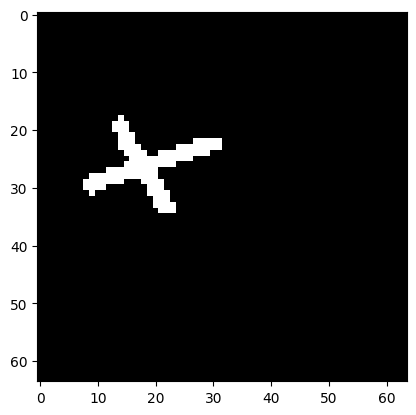

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [38]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    print(lab)
    break

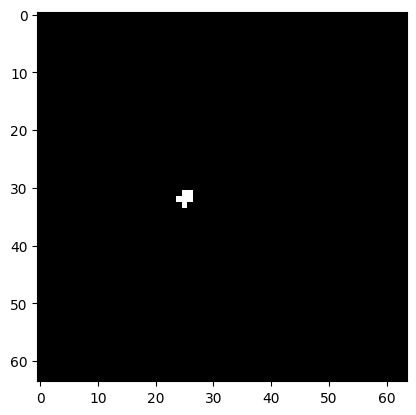

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [39]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [40]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

In [41]:
len(class_counts.keys())

44

# Define Model Hyperparameters

In [42]:

model_checkpoint_path: str = os.path.join(
    model_save_dirpath,
    "Echo_epoch2056_trainacc0.97426_valacc1.0_Tloss0.0062137_Vloss0.00043838_lr2.026109453287853e-11.pkl"
)

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": model_checkpoint_path
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.001,
        "weight_decay": 0.0001
    }
]


In [43]:
len(val_dataloader)

10

# Train

In [ ]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(weight=weights_tensor.to(device="cuda")),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        train_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Skipping encoder_conv_blocks.1.0.weight:  loaded size:torch.Size([16, 16, 3, 3]) != model size:  torch.Size([32, 16, 3, 3])
Skipping encoder_conv_blocks.1.0.bias:  loaded size:torch.Size([16]) != model size:  torch.Size([32])
Skipping encoder_conv_blocks.1.2.weight:  loaded size:torch.Size([16]) != model size:  torch.Size([32])
Skipping encoder_conv_blocks.1.2.bias:  loaded size:torch.Size([16]) != model size: 

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


Train Accuracy      : 0.0270700640976429
Val Accuracy        : 0.05095541477203369
Loss                : 10.51938247680664
Val Loss            : 10.723649024963379
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Train Accuracy      : 0.08757961541414261
Val Accuracy        : 0.06369426846504211
Loss                : 10.358499526977539
Val Loss            : 10.626496315002441
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Train Accuracy      : 0.08757961541414261
Val Accuracy        : 0.05095541477203369
Loss                : 10.362889289855957
Val Loss            : 10.265523910522461
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Train Accuracy      : 0.0843949019908905
Val Accuracy        : 0.10191082954406738
Loss                : 10.178698539733887
Val Loss            : 10.171270370483398
Learning Rate       : 0.001


Training model...:  48%|████▊     | 19/40 [00:15<00:16,  1.25it/s]